In [ ]:
#############################################################
# Author(s): Piyush, Kun-lin, Omika                       #
#############################################################

In [ ]:
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)
import numpy as np
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))
from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

!pip install Neural-Decoding

%matplotlib inline
from scipy import io
from scipy import stats

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

#Import decoder functions
from Neural_Decoding.decoders import SimpleRNNClassification
from Neural_Decoding.decoders import GRUClassification
from Neural_Decoding.decoders import LSTMClassification
from Neural_Decoding.decoders import WienerFilterClassification
from Neural_Decoding.decoders import SVClassification
from Neural_Decoding.decoders import DenseNNClassification
from Neural_Decoding.decoders import GRUClassification
from Neural_Decoding.decoders import XGBoostClassification

In [ ]:
# dat = alldat[10] ##12(2) ##6(12) ##9(23) ##7 ##7
# regions = ["vis ctx", "thal", "hipp", "motor cortex", "midbrain", "basal ganglia", "cortical subplate", "other"]
# brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
#                 ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
#                 ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
#                 ["MOp", "MOs"], # non-visual cortex
#                 ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
#                 ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
#                 ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
#                 ]

# nareas = 7 # only the top 4 regions are in this particular mouse
# NN = len(dat['brain_area']) # number of neurons
# barea = nareas * np.ones(NN, ) # last one is "other"
# for j in range(nareas):
#   barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
# response = dat['response'] # right - nogo - left (-1, 0, 1)
# vis_right = dat['contrast_right'] # 0 - low - high
# vis_left = dat['contrast_left'] # 0 - low - high
# dt = dat['bin_size'] # binning at 10 ms
# NT = dat['spks'].shape[-1]
# num_neuron = []
# for i in range(8):
#   num_neuron.append([(barea==i).sum()])
# print(num_neuron)

In [ ]:
dat = alldat[11] ##12(2) ##6(12) ##9(23) ##7 ##7
regions = ["vis ctx", "thal", "hipp", "motor cortex", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["LGd", "LP"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["MOp", "MOs"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

nareas = 7 # only the top 4 regions are in this particular mouse
NN = len(dat['brain_area']) # number of neurons
barea = nareas * np.ones(NN, ) # last one is "other"
for j in range(nareas):
  barea[np.isin(dat['brain_area'], brain_groups[j])] = j # assign a number to each region
response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
dt = dat['bin_size'] # binning at 10 ms
NT = dat['spks'].shape[-1]
num_neuron = []
for i in range(8):
  num_neuron.append([(barea==i).sum()])
print(num_neuron)

[[145], [11], [220], [6], [0], [0], [0], [316]]


In [ ]:
cont_diff = 0.25  ## lower bound .25/.75 for good/bad
cont_diff2 = 1.  ## upper bound   .75/1. for left right

# high_contrast_right = ((vis_right - vis_left) >= cont_diff)
# high_contrast_left = ((vis_right - vis_left) <= -cont_diff)
# high_contrast = np.logical_or(high_contrast_right, high_contrast_left)

high_contrast_right = np.logical_and((vis_right - vis_left) >= cont_diff, cont_diff2 >= (vis_right - vis_left))
high_contrast_left = np.logical_and((vis_right - vis_left) <= -cont_diff, -cont_diff2 <= (vis_right - vis_left))
high_contrast = np.logical_or(high_contrast_right, high_contrast_left)

# right - nogo - left (-1, 0, 1)
correct_right = np.logical_and(high_contrast_right, (response==-1)) ## should choose right and correct
wrong_right_wc = np.logical_and(high_contrast_right, (response==1)) ## choice wrong side
wrong_right_no_choice = np.logical_and(high_contrast_right, (response == 0))
wrong_right = np.logical_or(wrong_right_wc , wrong_right_no_choice)

## for wrong right choice, it means the contrast is bigger in
## the right side but mice choose left

# right - nogo - left (-1, 0, 1)
correct_left = np.logical_and(high_contrast_left, (response==1)) ## should choose right and correct
wrong_left_wc = np.logical_and(high_contrast_left, (response==-1)) ## choice wrong side
wrong_left_no_choice = np.logical_and(high_contrast_left, (response == 0))
wrong_left = np.logical_or(wrong_left_wc , wrong_left_no_choice)

correct_all = np.logical_or(correct_right, correct_left)
wrong_all = np.logical_or(wrong_right, wrong_left)
wrong_wc_all = np.logical_or(wrong_right_wc, wrong_left_wc)
wrong_no_choice_all = np.logical_or(wrong_right_no_choice, wrong_left_no_choice)


print(high_contrast_right.sum())
print(correct_right.sum())
print(wrong_right_wc.sum())
print(wrong_right_no_choice.sum())

print('__________')

print(high_contrast_left.sum())
print(correct_left.sum())
print(wrong_left_wc.sum())
print(wrong_left_no_choice.sum())

print('__________')

# right - nogo - left (-1, 0, 1)
print((response==-1).sum())
print((response==0).sum())
print((response==1).sum())

print('__________')

print((correct_all).sum())
print((wrong_all).sum())

111
89
9
13
__________
103
97
5
1
__________
141
64
135
__________
186
28


In [ ]:
wheel_data = np.ones((340, 250))
for i in range(340):
  for j in range(250):
    wheel_data[i][j] = dat["wheel"][:, i, j]
print(wheel_data)

[[ 0.  0. -1. ...  0.  0.  0.]
 [-1. -1. -1. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... -2. -2. -2.]]


In [ ]:
#finding the trials where there was motion vs no motion
no_motion_ind = np.array([])
motion_ind = np.array([])
for i in dat["response"]:
  if i == 0: # define a no motion trial
    no_motion_ind = np.append(no_motion_ind, [i])
  if i != 0: # define a motion trial
    motion_ind = np.append(motion_ind, [i])
print(no_motion_ind.shape)
print(motion_ind.shape)

(64,)
(276,)


In [ ]:
# find the indices of the motor cortical neurons
# note there are only 6 neurons in the motor cortex
motor_ind = np.array([])
for i in range(698):
  if int(barea[i]) == 3:
    motor_ind = np.append(motor_ind, [i])
print(motor_ind.shape)

(6,)


In [ ]:
same_contrast = ((vis_right - vis_left) == 0)

# right - nogo - left (-1, 0, 1)
same_contrast_left = np.logical_and(same_contrast, (response==1))
same_contrast_right = np.logical_and(same_contrast, (response==-1))
same_contrast_no_choice = np.logical_and(same_contrast, (response==0))

print(same_contrast.sum())
print(same_contrast_left.sum())
print(same_contrast_right.sum())
print(same_contrast_no_choice.sum())

126
29
47
50


In [ ]:
range(2,3)

range(2, 3)

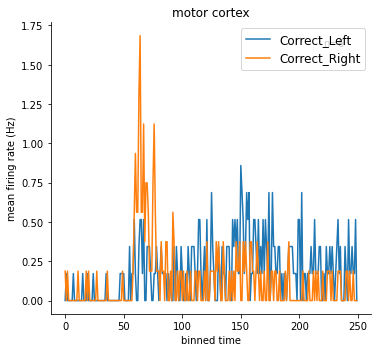

In [ ]:
#@title plots by brain region and correct/incorrect trials
rcParams['figure.figsize'] = [36, 5]
for j in range(3,4):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,correct_left].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,correct_right].mean(axis=(0,1)))
  plt.text(.85, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==3:
    plt.legend(['Correct_Left', 'Correct_Right'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


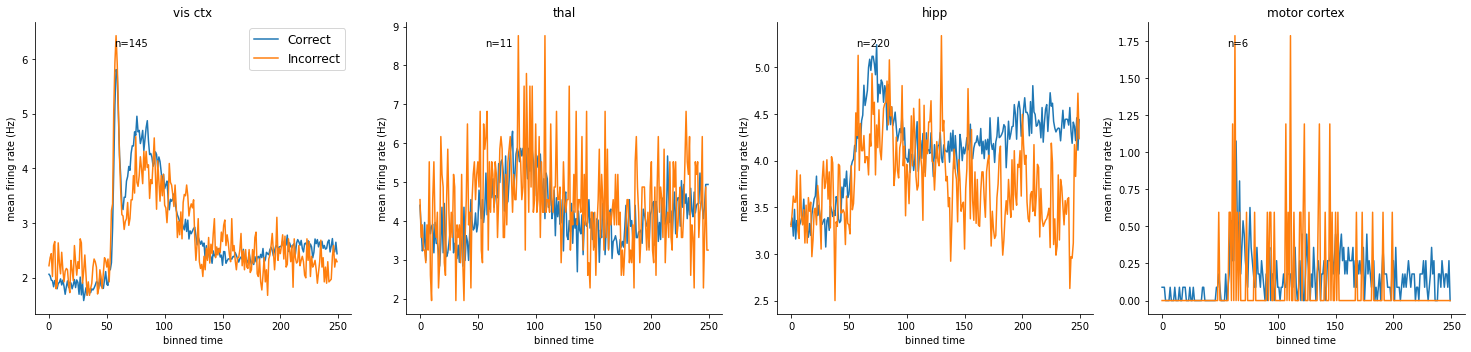

In [ ]:
#@title plots by brain region and correct/incorrect trials
rcParams['figure.figsize'] = [36, 5]
for j in range(4):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,correct_all].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_all].mean(axis=(0,1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['Correct', 'Incorrect'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


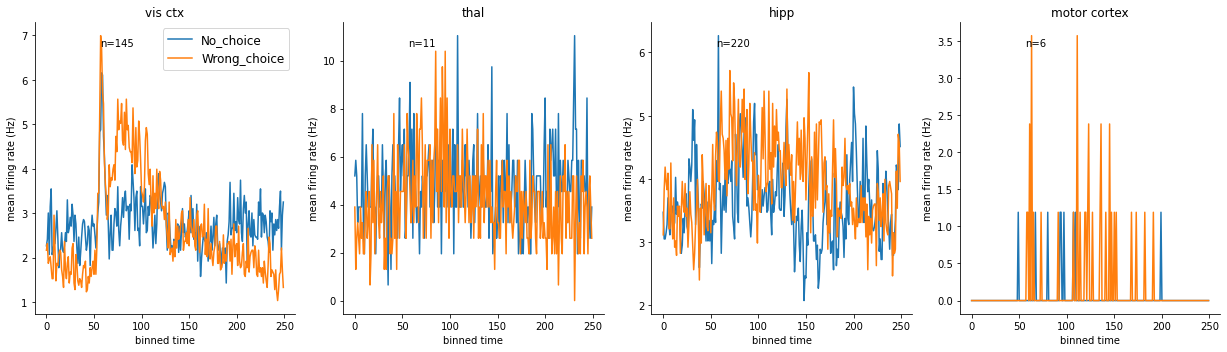

In [ ]:
#@title plots by brain region and correct/incorrect trials
rcParams['figure.figsize'] = [30, 5]
for j in range(4):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_no_choice_all].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_wc_all].mean(axis=(0,1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['No_choice', 'Wrong_choice'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


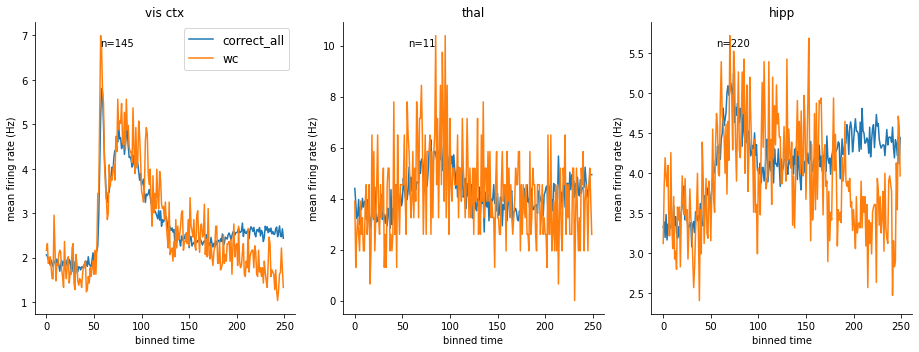

In [ ]:
#@title plots by brain region and correct/incorrect trials
rcParams['figure.figsize'] = [30, 5]
for j in range(3):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,correct_all].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_wc_all].mean(axis=(0,1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['correct_all', 'wc'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice.
  import sys
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/usr/local/lib/python3.6/dist-p

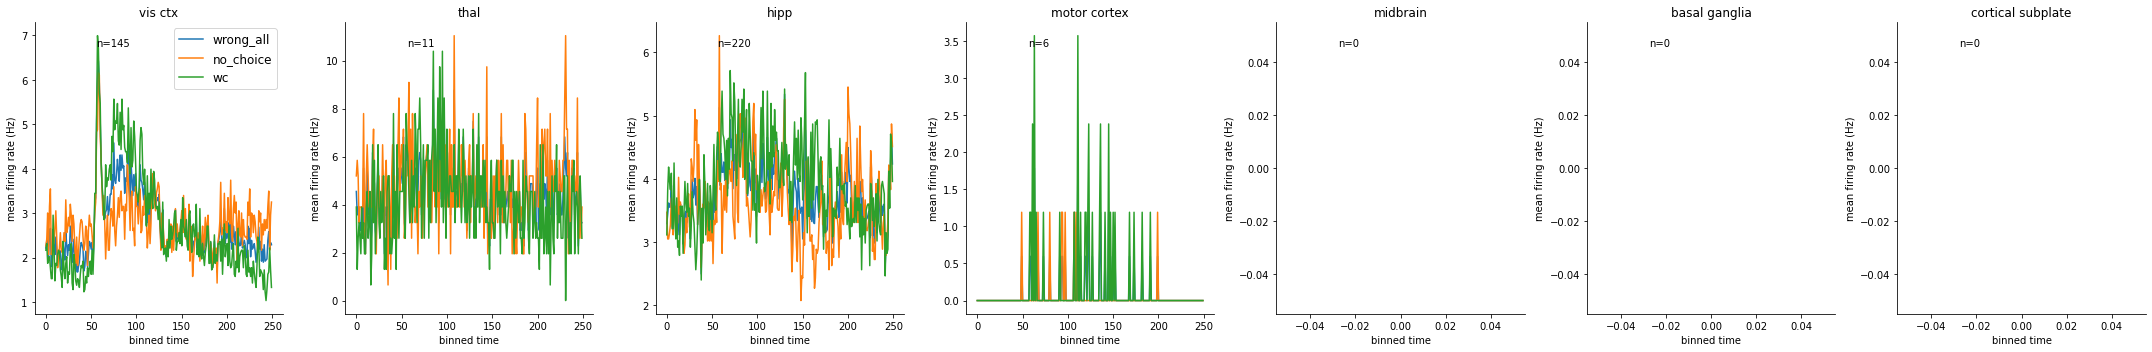

In [ ]:
#@title plots by brain region and correct/incorrect trials
rcParams['figure.figsize'] = [30, 5]
for j in range(7):
  ax = plt.subplot(1,nareas,j+1)
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_all].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_no_choice_all].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,wrong_wc_all].mean(axis=(0,1)))
  plt.text(.25, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==0:
    plt.legend(['wrong_all','no_choice', 'wc'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])


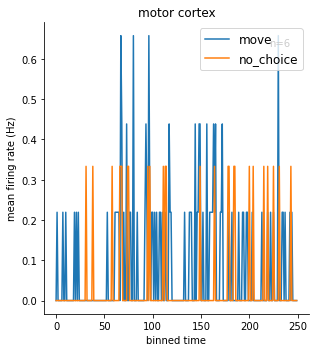

In [ ]:
for j in range(3,4):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,np.logical_or(same_contrast_left,same_contrast_right)].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,same_contrast_no_choice].mean(axis=(0,1)))
  plt.text(.85, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==3:
    plt.legend(['move', 'no_choice'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])

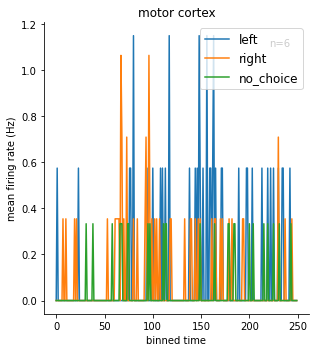

In [ ]:
for j in range(3,4):
  ax = plt.subplot(1,nareas,j+1)
  
  plt.plot(1/dt *  dat['spks'][barea==j][:,same_contrast_left].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,same_contrast_right].mean(axis=(0,1)))
  plt.plot(1/dt *  dat['spks'][barea==j][:,same_contrast_no_choice].mean(axis=(0,1)))
  plt.text(.85, .92, 'n=%d'%np.sum(barea==j), transform=ax.transAxes)
 
  if j==3:
    plt.legend(['left', 'right', 'no_choice'], fontsize=12)
  ax.set(xlabel = 'binned time', ylabel = 'mean firing rate (Hz)', title = regions[j])

In [ ]:
motion = (dat["response"] != 0)
no_motion = (dat["response"] == 0)

In [ ]:
# classify good left from good right
X_in = dat['spks'][barea==1][:,correct_all].transpose((1,2,0))
y = response
y[correct_right] = 0
y[correct_left] = 1
y = y[correct_all]


In [ ]:
#classify motion from no motion trials
X_in = dat['spks'][barea==3][:,motion].transpose((1,2,0))
y = response
y[correct_right] = 0
y[correct_left] = 1
y = y[correct_all]

In [ ]:
# classify movement/no-movement in same contrast trials
X_in = dat['spks'][barea==2][:,same_contrast].transpose((1,2,0))
y = response
y[np.logical_or(same_contrast_right, same_contrast_left)] = 0
y[same_contrast_no_choice] = 1
y = y[same_contrast]

In [ ]:
# classcify correct all from wrong all
# X_in = dat['spks'][barea==0][:,np.logical_or(correct_all, wrong_all)].transpose((1,2,0))
# y = response
# y[correct_all] = 0
# y[wrong_all] = 1
# y = y[np.logical_or(correct_all, wrong_all)]

In [ ]:
#Set what part of data should be part of the training/testing/validation sets
num_examples=X_in.shape[0]
training_range=[0, 0.75]
valid_range=[0.75,1]

training_set=np.arange(np.int(np.round(training_range[0]*num_examples)),np.int(np.round(training_range[1]*num_examples)))
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples)),np.int(np.round(valid_range[1]*num_examples)))

import random
int_list = np.array([ x for x in range(num_examples)])

/usr/local/lib/python3.6/dist-packages/Neural_Decoding/decoders.py:1225: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(X_flat_train,y_train,nb_epoch=self.num_epochs,verbose=self.verbose) #Fit the model


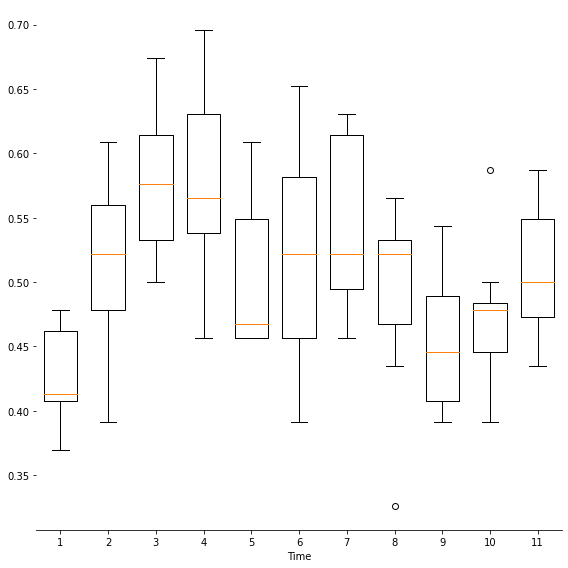

In [ ]:

y_valid_acc=np.zeros((8))
y_valid_acc_all=np.zeros((8,11))
for k in np.arange(0, 210, 20):
  X = X_in[:,k:k+50,:]
  X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
  for i in range(8):
    random.shuffle(int_list)

    X_flat_train=X_flat[int_list[training_set],:]
    X_flat_valid=X_flat[int_list[valid_set],:]

    y_train = y[int_list[training_set]]
    y_valid = y[int_list[valid_set]]

    model_dnn=DenseNNClassification(units=100,dropout=0,num_epochs=5,verbose=0)

    model_dnn.fit(X_flat_train,y_train)

    y_valid_predicted_dnn = model_dnn.predict(X_flat_valid)
    # y_valid_acc[i]=(y_valid_predicted_dnn == y_valid[:,0]).mean()
    y_valid_acc[i]=(y_valid_predicted_dnn == y_valid).mean()
  y_valid_acc_all[:,k//20] = y_valid_acc

f, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(y_valid_acc_all, vert=True, widths=0.7)
ax.set(
  xlabel="Time",
)
ax.spines["left"].set_visible(False)

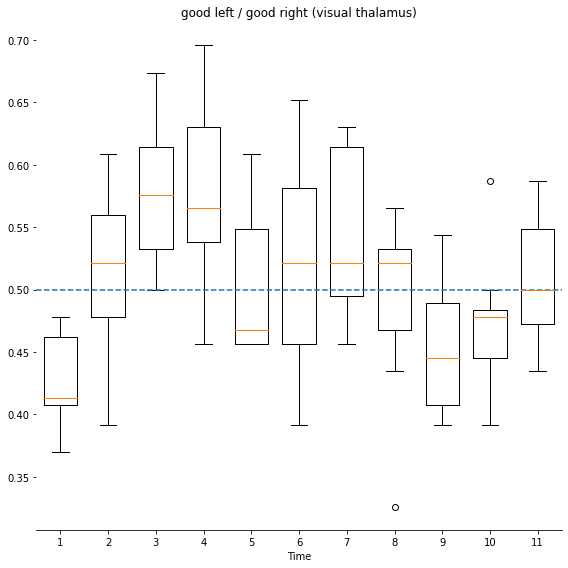

In [ ]:
# plotgood_left/right = y_valid_acc_all   0.25/1 contrast
plotgood_bad = y_valid_acc_all
f, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(plotgood_bad, vert=True, widths=0.7)
ax.plot([0.5,11.5], [0.5, 0.5], '--')
ax.set(
  xlabel="Time",
  title="good left / good right (visual thalamus)"
)
ax.spines["left"].set_visible(False)

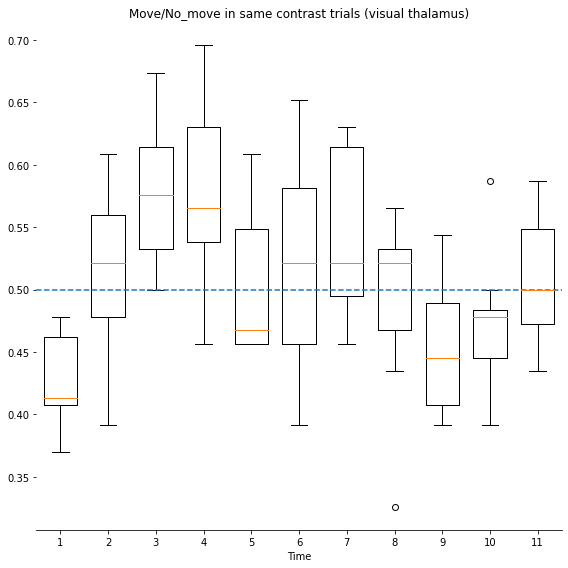

In [ ]:
plotmove_nomove = y_valid_acc_all
f, ax = plt.subplots(figsize=(8, 8))
ax.boxplot(plotmove_nomove, vert=True, widths=0.7)
ax.plot([0.5,11.5], [0.5, 0.5], '--')
ax.set(
  xlabel="Time",
  title ="Move/No_move in same contrast trials (visual thalamus)"
)
ax.spines["left"].set_visible(False)